# Intro to Pytorch - MNIST Digit Classification

In this notebook, we cover the basics of PyTorch and will train our first (shallow) neural network from scratch on the MNIST digit classification dataset.

Let's start by importing the libraries that we will need and setting up jupyter. You can add additional imports later and re-run the cell to make those imports available throughout the notebook.

In [1]:
# ipython magic that ensures that plots are inlined and saved along with the notebook
%matplotlib inline

# import numpy - array processing library
import numpy as np 

# pytorch imports:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# pytorch functionality for image datasets
from torchvision import datasets, transforms

# standard plotting library
import matplotlib.pyplot as plt

We supply you with a function to plot multiple images along with their labels. Please ignore for now:

In [2]:
def show_image_grid(X, y=None, title=None, nrow=6, ncol=4, **kwargs):
    max_num = nrow*ncol
    X = X[:max_num]
    if len(X) < max_num:
        ncol = len(X) // nrow + 1
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    if X.dim() != 4:
        X = X[:, None]

    plt.figure(title, figsize=(2*nrow, 2*ncol + (0 if y is None else 1)))
    if title:
        plt.title(title)
        
    y = [None] * len(X) if y is None else y
    if isinstance(y, torch.Tensor):
        y = y.numpy()
        
    for i, (Xi, yi) in enumerate(zip(X, y)):
        plt.subplot(ncol, nrow, i+1)
        img = Xi.numpy().transpose((1, 2, 0))
        if img.shape[2] == 1:
            img = img[..., 0]
        plt.imshow(img)
        if yi is not None:
            plt.title(str(yi))
        plt.axis('off')
    
    plt.axis('off')


## Some PyTorch basics

Creating tensors:

In [3]:
V = torch.tensor([1., 2., 3.])
V

tensor([1., 2., 3.])

In [4]:
M = torch.tensor([[1., 2., 3.], [4., 5., 6]])
M

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [5]:
# Create a 3D tensor of size 2x2x2.
T = torch.tensor([[[1., 2.], [3., 4.]],
          [[5., 6.], [7., 8.]]])
T

tensor([[[1., 2.],
         [3., 4.]],

        [[5., 6.],
         [7., 8.]]])

In [6]:
# create a tensor with random numbers
torch.randn((3, 2, 5, 2))

tensor([[[[ 0.2023,  2.4365],
          [ 1.5235,  0.3136],
          [-0.1725,  2.0450],
          [ 1.0513, -3.0113],
          [ 1.9477,  0.8964]],

         [[ 0.7966,  1.7909],
          [ 0.2203,  0.8977],
          [ 1.0592,  0.5051],
          [-0.1172, -0.1964],
          [-0.6481,  0.4154]]],


        [[[-0.9966,  0.4326],
          [-0.7480,  1.1857],
          [ 0.2611, -0.6793],
          [-1.4389,  0.4017],
          [ 1.0047,  0.1642]],

         [[-1.6396, -1.9281],
          [-0.8798,  0.7390],
          [-0.1424,  0.2104],
          [ 0.8403, -1.3880],
          [ 0.0588,  0.6995]]],


        [[[ 1.0181,  0.0693],
          [ 2.2290,  0.8302],
          [-0.4961,  0.4396],
          [ 0.1260,  2.7948],
          [ 0.3170, -1.4874]],

         [[-0.1779, -0.2361],
          [-1.0006,  0.8396],
          [-1.9743,  1.1977],
          [-0.7920,  0.1232],
          [-0.5277, -1.8741]]]])

Indexing into tensors gives you elements or tensor views:

In [7]:
V[0]

tensor(1.)

In [8]:
V[0].item()

1.0

In [9]:
M[0]

tensor([1., 2., 3.])

In [10]:
M[0, 1]

tensor(2.)

Fancy indexing:

In [11]:
M[:, 0]

tensor([1., 4.])

Typical mathematical operators are overloaded for tensors, so you can add all entries of one matrix to another matrix with a simple line. No need to write for loops :)

In [12]:
A = torch.randn((3, 2))
A

tensor([[-0.5781,  0.2518],
        [ 0.3376, -0.5409],
        [ 0.5412, -0.6992]])

In [13]:
B = torch.randn((3, 2))
B

tensor([[-0.0039,  0.9286],
        [ 1.5287, -1.2031],
        [ 1.0134, -1.2150]])

In [14]:
A + B

tensor([[-0.5820,  1.1804],
        [ 1.8662, -1.7440],
        [ 1.5546, -1.9143]])

In [15]:
A * B

tensor([[0.0022, 0.2338],
        [0.5161, 0.6507],
        [0.5485, 0.8496]])

In [16]:
2 * A

tensor([[-1.1563,  0.5036],
        [ 0.6752, -1.0817],
        [ 1.0824, -1.3985]])

## Let's get started: loading the data

First, lets load the dataset:

In [17]:
train_data = datasets.MNIST(root='./data', train=True, 
                            download=True, transform=transforms.ToTensor())
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In order to sample from this dataset, we need a DataLoader. A DataLoader samples mini batches from a DataSet and can also be used to apply transformations to the data (here, we just want to transform the data to a pytorch tensor).

In [18]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
train_loader

MNIST also provides a validation set that we can use to test how well our model performs.

In [19]:
valid_data = datasets.MNIST(root='./data', train=False, 
                            download=True, transform=transforms.ToTensor())
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=False, batch_size=batch_size)

Lets sample one batch of data from the dataset:

In [20]:
Xb, yb = next(iter(train_loader))

In [21]:
Xb.shape

torch.Size([128, 1, 28, 28])

In [22]:
Xb[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.6667,
          0.4275, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

We can use matplotlib or the show_image_grid function to visualize the data.

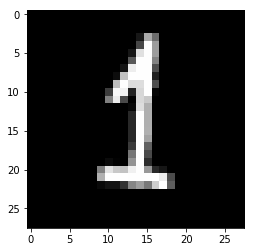

In [23]:
plt.gray() # sets matplotlib colormap
plt.imshow(Xb[0,0])

In [24]:
yb

tensor([1, 1, 3, 5, 8, 1, 5, 7, 0, 4, 5, 9, 3, 2, 7, 3, 7, 3, 5, 6, 9, 5, 6, 8,
        2, 2, 2, 4, 0, 1, 4, 1, 0, 6, 7, 6, 2, 0, 2, 7, 2, 1, 1, 0, 4, 1, 3, 0,
        6, 3, 6, 6, 1, 7, 7, 8, 5, 7, 9, 1, 4, 1, 4, 3, 1, 7, 3, 6, 9, 0, 1, 6,
        1, 8, 1, 8, 2, 9, 4, 7, 6, 2, 8, 3, 2, 6, 3, 8, 9, 9, 9, 3, 8, 9, 8, 6,
        5, 6, 2, 7, 0, 1, 3, 1, 2, 1, 3, 9, 6, 2, 5, 8, 4, 0, 1, 7, 5, 0, 5, 5,
        3, 9, 2, 7, 4, 5, 2, 7])

tensor(1)

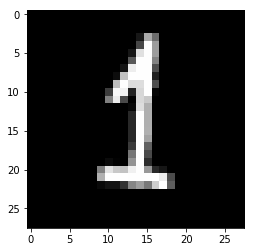

In [25]:
plt.imshow(Xb[0, 0])
yb[0]

tensor(1)

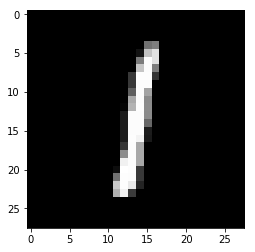

In [26]:
plt.imshow(Xb[1, 0])
yb[1]

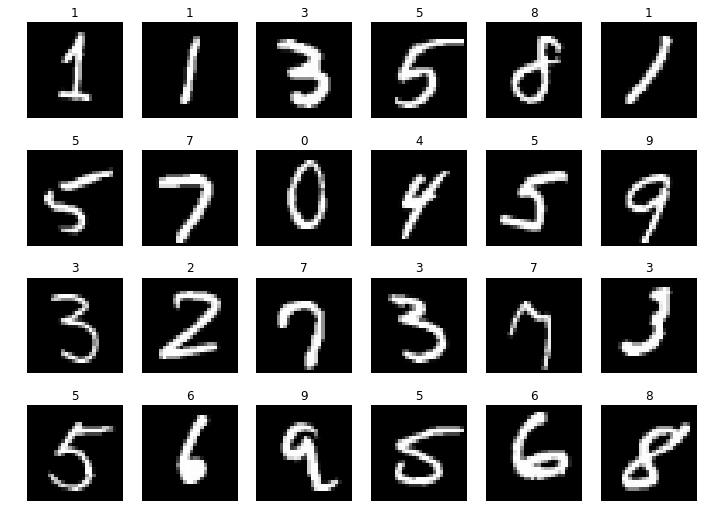

In [27]:
show_image_grid(Xb, yb)

## Setup the model

We want to train a linear model from a vectorized (flattened) version of the image. We first reshape our image tensor

In [28]:
Xb_flat = Xb.view(Xb.shape[0], -1)
Xb_flat.shape

torch.Size([128, 784])

We now initialize the weights and biases (parameters) of our network. We use a weight matrix to densely connect the 28x28 dimensional input to an output layer of size 10 and add a bias term. This simplistic shallow linear "neural network" outputs 10 class scores for each of the digit between 0-9.

In [29]:
weight = torch.randn((28*28, 10), requires_grad=True)
bias = torch.zeros(10, requires_grad=True)

output = Xb_flat @ weight  + bias
output.shape

torch.Size([128, 10])

In [30]:
output[0]

tensor([-12.9499,  -7.5915,  -1.5107,  -7.8935,  -1.2034,  -2.5946,  -2.3174,
         -1.1106,  -4.6926, -12.9689], grad_fn=<SelectBackward>)

Lets refactor our neural network forward pass and wrap it into a function that we can easily call later on

In [31]:
def model(X, weight, bias):
    return X.view(-1, 28*28) @ weight + bias

model(Xb, weight, bias)[0]

tensor([-12.9499,  -7.5915,  -1.5107,  -7.8935,  -1.2034,  -2.5946,  -2.3174,
         -1.1106,  -4.6926, -12.9689], grad_fn=<SelectBackward>)

## Metrics

We will also need a way of measuring how good our model is. Here, we will use the classification accuracy by comparing the label predicted by the network (simply the neuron with the largest score of our output layer) with the actual labels and counting how often those agree.

In [32]:
print("predicted label:", output.argmax(1))
print("   actual label:", yb)

yb == output.argmax(1)

predicted label: tensor([7, 5, 7, 9, 4, 4, 9, 9, 9, 4, 9, 9, 7, 5, 1, 1, 9, 4, 9, 1, 9, 9, 4, 6,
        5, 7, 4, 1, 5, 4, 4, 4, 4, 4, 4, 1, 4, 5, 7, 7, 4, 4, 4, 1, 1, 4, 7, 1,
        4, 5, 1, 1, 7, 4, 4, 4, 5, 1, 3, 4, 4, 4, 4, 7, 4, 1, 4, 1, 1, 4, 4, 6,
        4, 7, 4, 4, 1, 9, 1, 3, 1, 4, 4, 5, 6, 1, 4, 1, 7, 1, 6, 7, 4, 4, 1, 4,
        1, 1, 4, 4, 1, 4, 4, 4, 7, 4, 4, 4, 1, 1, 9, 1, 1, 1, 5, 3, 9, 9, 9, 9,
        4, 1, 4, 9, 4, 2, 4, 4])
   actual label: tensor([1, 1, 3, 5, 8, 1, 5, 7, 0, 4, 5, 9, 3, 2, 7, 3, 7, 3, 5, 6, 9, 5, 6, 8,
        2, 2, 2, 4, 0, 1, 4, 1, 0, 6, 7, 6, 2, 0, 2, 7, 2, 1, 1, 0, 4, 1, 3, 0,
        6, 3, 6, 6, 1, 7, 7, 8, 5, 7, 9, 1, 4, 1, 4, 3, 1, 7, 3, 6, 9, 0, 1, 6,
        1, 8, 1, 8, 2, 9, 4, 7, 6, 2, 8, 3, 2, 6, 3, 8, 9, 9, 9, 3, 8, 9, 8, 6,
        5, 6, 2, 7, 0, 1, 3, 1, 2, 1, 3, 9, 6, 2, 5, 8, 4, 0, 1, 7, 5, 0, 5, 5,
        3, 9, 2, 7, 4, 5, 2, 7])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0], dtype=torch.uint8)

We can compute an accuracy between 0 and 1 simply by averaging the above binary vector. 

In [33]:
def accuracy(output, label):
    return (output.argmax(1) == label).float().mean()

accuracy(output, yb)

tensor(0.0859)

## Loss

To measure how well our network does, we cannot directly use our accuracy metric - Do you know why?

Instead, we will apply a softmax to the 10-dimensional output, which gives us a probability between 0 and 1 for each of the 10 classes.

In [34]:
F.softmax(output, dim=1)

tensor([[2.2994e-06, 4.8835e-04, 2.1360e-01,  ..., 3.1866e-01, 8.8651e-03,
         2.2561e-06],
        [3.4973e-03, 1.9490e-01, 2.1078e-02,  ..., 5.8025e-04, 1.4219e-03,
         1.2969e-05],
        [1.0843e-13, 1.2997e-02, 7.8677e-09,  ..., 9.8547e-01, 7.8119e-13,
         1.5139e-03],
        ...,
        [6.4727e-08, 2.4808e-03, 9.6684e-01,  ..., 6.6150e-04, 9.0303e-10,
         5.8757e-05],
        [9.8509e-10, 4.5719e-01, 2.8262e-08,  ..., 1.2003e-05, 8.4198e-06,
         2.6053e-11],
        [7.6654e-13, 8.6485e-06, 4.3304e-08,  ..., 1.9611e-04, 1.4368e-10,
         1.3260e-05]], grad_fn=<SoftmaxBackward>)

In [35]:
F.softmax(output, dim=1).sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [36]:
F.softmax(output, dim=1)[0]

tensor([2.2994e-06, 4.8835e-04, 2.1360e-01, 3.6105e-04, 2.9044e-01, 7.2253e-02,
        9.5336e-02, 3.1866e-01, 8.8651e-03, 2.2561e-06],
       grad_fn=<SelectBackward>)

In [37]:
F.softmax(output, dim=1)[1]

tensor([3.4973e-03, 1.9490e-01, 2.1078e-02, 2.1308e-06, 5.9252e-02, 7.0041e-01,
        1.8854e-02, 5.8025e-04, 1.4219e-03, 1.2969e-05],
       grad_fn=<SelectBackward>)

However, instead of computing the negative log-likelihood now from the softmax output, it is both quicker and numerically more stable to directly use the cross_entropy loss from PyTorch. Notice that you need to pass the output of your last layer directly to cross_entropy - NEVER pass softmaxed output directly, use the explicit softmax presented above only if you want to output class probabilities at test time. 

In [38]:
loss = F.cross_entropy(output, yb)
loss

tensor(14.8453, grad_fn=<NllLossBackward>)

## Backpropagation

We now need to compute the gradient of the weight and bias tensor with respect to the loss. Luckily, PyTorch supplies us with an autograd mechanism that internally computes the gradients at each operations and propagates the error from the output of the network to the input, often called the backward pass.

The gradients of a tensor can be accessed by the .grad attribute after running backward on the output as follows. At first, the gradient is empty:

In [39]:
bias.grad

We then run backpropagation by calling:

In [40]:
loss.backward()

Then, we can read out the gradient:

In [41]:
bias.grad

tensor([-0.0779,  0.0919, -0.1034, -0.0851,  0.3051, -0.0235, -0.0702, -0.0194,
        -0.0715,  0.0540])

### Question

What is the shape of the gradient of bias and weight?

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

-

In [42]:
bias.grad.shape

torch.Size([10])

In [43]:
weight.grad.shape

torch.Size([784, 10])

In [44]:
weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## Gradient descent

We can now change the weight and bias parameter in order to bring down the loss. Since we don't want to backpropagate through this gradient update step, we need to disable the autograd feature for these steps using with no_grad. We also need to define a learning rate (lr).

In [45]:
lr = 1.e-1

print("bias before: ", bias)

with torch.no_grad():
    weight -= lr * weight.grad
    weight.grad.zero_()
    bias -= lr * bias.grad
    bias.grad.zero_()
    
print("bias after: ", bias)

bias before:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)
bias after:  tensor([ 0.0078, -0.0092,  0.0103,  0.0085, -0.0305,  0.0024,  0.0070,  0.0019,
         0.0071, -0.0054], requires_grad=True)


Did our model already improve after this one small mini batch gradient update?

In [46]:
output = model(Xb, weight, bias)
F.cross_entropy(output, yb)

tensor(14.0852, grad_fn=<NllLossBackward>)

In [47]:
accuracy(output, yb)

tensor(0.0703)

# Full Training Loop

In practice, we want to do these gradient update steps multiple times over the whole dataset. Usually, we construct an inner loop that runs over the whole (shuffled!) training set, and an outer loop that repeats this pass over the whole training for a set number of epochs.

Also, we were not very smart in initializing our weights. Lets use the popular kaiming initialization for initializing the weight matrix. Initialization is quite important, but as we will see later most of the times PyTorch provides us with a safe default. We just don't use it here since we did not yet learn about nn.Modules, yet.

We also measure the accuracy on our validation set after each epoch in this loop:

In [48]:
lr = 0.1

# initialize weights
weight = torch.zeros((28*28, 10), requires_grad=True)
nn.init.kaiming_uniform_(weight, mode='fan_out')
bias = torch.zeros(10, requires_grad=True)

for epoch in range(5):
    # train on mini batches
    losses = []
    for X, y in train_loader:
        # forward pass
        output = model(X, weight, bias)
        # compute loss
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())
        # backward pass
        loss.backward()
        # gradient descent update
        with torch.no_grad():
            weight -= lr * weight.grad
            bias -= lr * bias.grad
            weight.grad.zero_()
            bias.grad.zero_()
            
    # measure accuracy on the validation set
    acc = np.mean([
        accuracy(model(X, weight, bias), y)
        for X, y in valid_loader
    ])
    print("epoch % 5d: loss: % 8.5f accuracy: %4.2f" % (epoch, np.mean(losses), acc.item()))


epoch     0: loss:  0.57980 accuracy: 0.90
epoch     1: loss:  0.37589 accuracy: 0.91
epoch     2: loss:  0.34380 accuracy: 0.91
epoch     3: loss:  0.32720 accuracy: 0.92
epoch     4: loss:  0.31643 accuracy: 0.92


## Lets take a look inside

Since our model is so simple, we can actually take a look at the learned parameters of the network, as the weight matrix is just a stack of vectorized 28x28 images itself. Basically, we have trained 10 linear digit detectors. Lets have a look:

In [49]:
W = weight.detach()
W.shape

torch.Size([784, 10])

In [50]:
W[:, 0]

tensor([-8.2284e-02, -4.3574e-02, -5.5765e-02,  7.7003e-02, -1.6245e-02,
        -6.3772e-02, -2.5606e-02,  7.1073e-02, -4.9816e-02, -3.8570e-02,
        -1.5415e-02,  8.5473e-02,  2.3797e-02,  5.6847e-02,  7.4506e-02,
         6.4113e-02,  3.7285e-02,  4.2257e-02,  5.1808e-02, -8.0045e-02,
         6.8571e-02,  6.5436e-02, -1.5961e-02,  3.4463e-02, -3.1239e-02,
        -4.2898e-02,  3.3842e-03,  3.3230e-02, -3.7361e-03, -8.8670e-03,
         2.7880e-03,  6.7037e-02,  1.3181e-02, -4.8452e-02, -1.1745e-02,
        -7.9726e-02,  5.6412e-02, -4.8268e-02, -8.0723e-02, -5.6218e-02,
         4.8691e-02, -7.4267e-02,  5.2405e-02, -4.3141e-02,  3.3175e-02,
         3.8789e-03,  4.0176e-02,  7.0909e-02, -4.5776e-02, -6.1333e-02,
        -1.9013e-02,  6.5981e-02, -5.5523e-02, -4.2972e-02, -6.0872e-02,
        -1.3206e-02, -7.6199e-02, -4.6711e-02,  7.6708e-02,  7.2464e-02,
         7.2172e-03, -2.1034e-02, -7.1289e-02, -8.5580e-02,  6.7306e-02,
        -7.0178e-02, -2.0490e-02,  2.2807e-02,  1.6

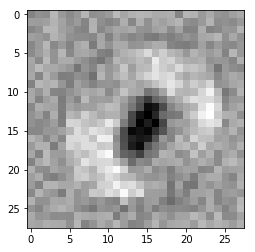

In [51]:
plt.imshow(W[:, 0].reshape(28, 28))

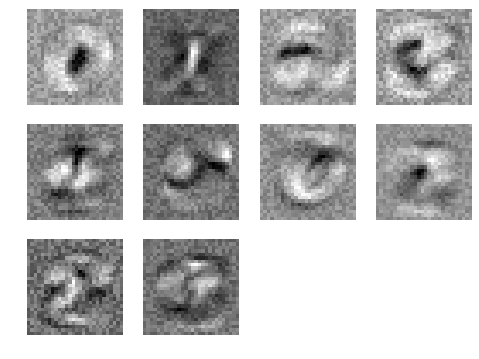

In [52]:
show_image_grid(W.reshape(28, 28, 10).permute(2, 0, 1), nrow=4)

## Simplifying our lives with pytorch.optim and nn.Module

Unless you have a good reason, there is no need to code like above in practice. PyTorch supplies us with comfortable classes for constructing neural networks (nn.Module), constructing layers (e.g. nn.Linear) and for stochastic gradient descent algorithms in pytorch.optim

Lets use those modules to refactor our training loop:

In [53]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 10, bias=True)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x
    
net = Net()
net

Net(
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [54]:
net = Net()
sgd = optim.SGD(net.parameters(), lr=1.e-1)

for epoch in range(5):
    # train on mini batches
    net.train()
    losses = []
    for X, y in train_loader:
        sgd.zero_grad()
        output = net(X)
        loss = F.cross_entropy(output, y)
        losses.append(loss.item())

        loss.backward()
        sgd.step()
            
    # measure accuracy on the validation set
    net.eval()
    with torch.no_grad():
        acc = np.mean([
            accuracy(net(X), y)
            for X, y in valid_loader
        ])
        print("epoch % 5d: loss: % 8.5f accuracy: %4.2f" % (epoch, np.mean(losses), acc.item()))

epoch     0: loss:  0.57360 accuracy: 0.90
epoch     1: loss:  0.37397 accuracy: 0.91
epoch     2: loss:  0.34215 accuracy: 0.91
epoch     3: loss:  0.32603 accuracy: 0.92
epoch     4: loss:  0.31537 accuracy: 0.92


## Simplifying our lives even further with additional libraries

We can simpify even further using additional libraries. [Poutyne](https://poutyne.org/) provides a simple training loop including callbacks. [fastai](https://github.com/fastai/fastai) is similar in this regard, but has an even higher level of abstraction and much more stuff included (they have a free online cours). Another alternative is [Keras](https://keras.io/) that is based on tensorflow. We also use [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) via [tensorboardX](https://tensorboardx.readthedocs.io/) in order to plot the loss and accuracy during training.

We will also take the code we prototyped here and put it into an executable python file in VSCode (@Oliver)

In [77]:
from poutyne.framework import Model
from poutyne.framework.callbacks import TensorBoardLogger
from tensorboardX import SummaryWriter

net = Net()
sgd = optim.SGD(net.parameters(), lr=1.e-1)
model = Model(net, sgd, 'cross_entropy', metrics=['accuracy']) 
model.cuda() 
model.fit_generator(
    train_loader, valid_loader,
    epochs=5,
    callbacks=[TensorBoardLogger(SummaryWriter())]
)

Epoch 1/5 5.47s Step 469/469: loss: 0.571431, acc: 86.228333, val_loss: 0.380430, val_acc: 90.130000
Epoch 2/5 5.68s Step 469/469: loss: 0.373345, acc: 89.775000, val_loss: 0.335915, val_acc: 90.800000
Epoch 3/5 5.48s Step 469/469: loss: 0.342097, acc: 90.498333, val_loss: 0.316224, val_acc: 91.280000
Epoch 4/5 5.55s Step 469/469: loss: 0.325709, acc: 91.003333, val_loss: 0.306083, val_acc: 91.580000
Epoch 5/5 5.50s Step 469/469: loss: 0.315252, acc: 91.226667, val_loss: 0.297954, val_acc: 91.730000


[{'epoch': 1,
  'loss': 0.5714310395558675,
  'time': 5.472436159849167,
  'acc': 86.22833333333334,
  'val_loss': 0.3804295210361481,
  'val_acc': 90.13},
 {'epoch': 2,
  'loss': 0.3733452877998352,
  'time': 5.677092030644417,
  'acc': 89.77499999186197,
  'val_loss': 0.3359154708623886,
  'val_acc': 90.8},
 {'epoch': 3,
  'loss': 0.3420966678619385,
  'time': 5.481374135240912,
  'acc': 90.49833332519532,
  'val_loss': 0.3162235161781311,
  'val_acc': 91.28},
 {'epoch': 4,
  'loss': 0.3257090063412984,
  'time': 5.55189105309546,
  'acc': 91.00333332519531,
  'val_loss': 0.3060828198432922,
  'val_acc': 91.58},
 {'epoch': 5,
  'loss': 0.3152516704161962,
  'time': 5.495405642315745,
  'acc': 91.22666667480469,
  'val_loss': 0.29795360612869265,
  'val_acc': 91.73}]

## Saving & Loading models

In [78]:
torch.save(net.state_dict(), 'mynet.pth')

Now, we can re-instantiate the network, for example when we restart our jupyter session after a couple days of training or if we want to use the model in production. However, all the weights are lost :(

In [79]:
net2 = Net()

print("label: ", yb[0])
print("predictions: ", F.softmax(net2(Xb[0]), dim=1))

label:  tensor(9)
predictions:  tensor([[0.0658, 0.0967, 0.1024, 0.0735, 0.0929, 0.1145, 0.1014, 0.1182, 0.1303,
         0.1042]], grad_fn=<SoftmaxBackward>)


So let's load the parameters from our checkpoint:

In [80]:
net2.load_state_dict(torch.load('mynet.pth'))
net2.eval() # needed when we use layers that behave different in training and testing (e.g. Batchnorm, Dropout)
print("label: ", yb[0])
print("predictions: ", F.softmax(net2(Xb[0]), dim=1))

label:  tensor(9)
predictions:  tensor([[0.0028, 0.0008, 0.0266, 0.0187, 0.1190, 0.0054, 0.0342, 0.0343, 0.3854,
         0.3728]], grad_fn=<SoftmaxBackward>)


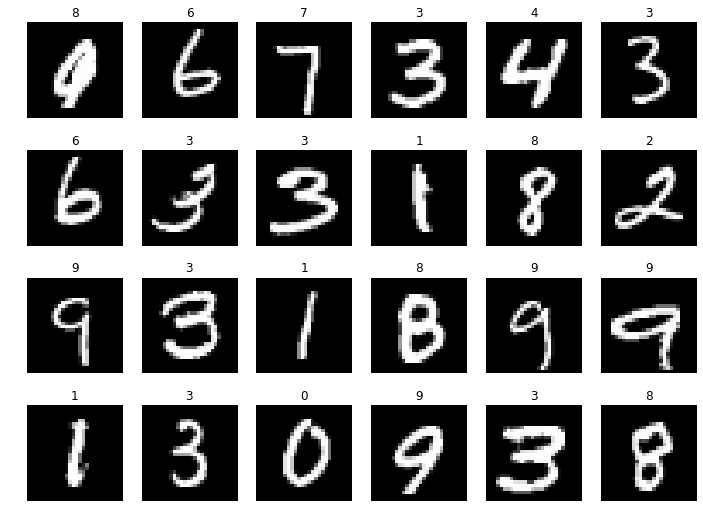

In [81]:
show_image_grid(Xb, net2(Xb).argmax(dim=1))

# Your Task:

 - What happens if you increase/decrease the learning rate?
 - Do you also observe that the training loss is less or at least not much higher then the validation loss? What does that mean?
 - What happens if you use a very small batch size (try 2 or 4)?
 - Does learning for more epochs improve performance?
 - Try adding more layers to the network
 - Try even more complex architectures and change the number of hidden neurons - can you get even better accuracy?
 - Visualize some images from the validation set that are misclassified - what can you see?
 - Instead of MNIST, try FashionMNIST, which has the same format but is much harder then MNIST
